Methodology
The process for conducting our research and modeling will follow the iterative OSEMiN pipeline. This entails Obtaining, Scrubbing, Exploring, Modeling, and Interpreting the data. This project will use this pipeline in the following manner:

OSEMiN Pipeline:

Obtain
- Import the data.

Scrub
- Manage datatypes, resolve missing/duplicate values.

Explore
- Find patterns among the relationships of variables in the dataset.  

Model
- Create predictive models.  

Interpret
– Identify insights and visualize findings.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from collections import Counter
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from scipy import stats
from math import log 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb 
from sklearn import svm
from sklearn.svm import SVC
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance

plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
#open dataset
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#getting data info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
#checking null values
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [5]:
#dropping duplicate rows 
df.drop_duplicates()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [6]:
# Check out spread of data and outliers
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


False    2850
True      483
Name: churn, dtype: int64

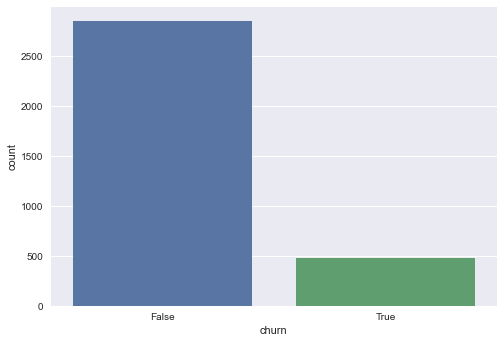

In [7]:
# Check balance of target data 
sns.countplot(x='churn', data=df);
df['churn'].value_counts()

In [8]:
# Check for nonsensical or placeholder values
# We can see that DC is included at the 51st State
for col in df.columns:
    print(col)
    print(df[col].unique())
    print('\n-----------------------------------------------\n')


state
['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']

-----------------------------------------------

account length
[128 107 137  84  75 118 121 147 117 141  65  74 168  95  62 161  85  93
  76  73  77 130 111 132 174  57  54  20  49 142 172  12  72  36  78 136
 149  98 135  34 160  64  59 119  97  52  60  10  96  87  81  68 125 116
  38  40  43 113 126 150 138 162  90  50  82 144  46  70  55 106  94 155
  80 104  99 120 108 122 157 103  63 112  41 193  61  92 131 163  91 127
 110 140  83 145  56 151 139   6 115 146 185 148  32  25 179  67  19 170
 164  51 208  53 105  66  86  35  88 123  45 100 215  22  33 114  24 101
 143  48  71 167  89 199 166 158 196 209  16  39 173 129  44  79  31 124
  37 159 194 154  21 133 224  58  11 109 102 165  18  30 176  47 190 152
  26  69 186

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

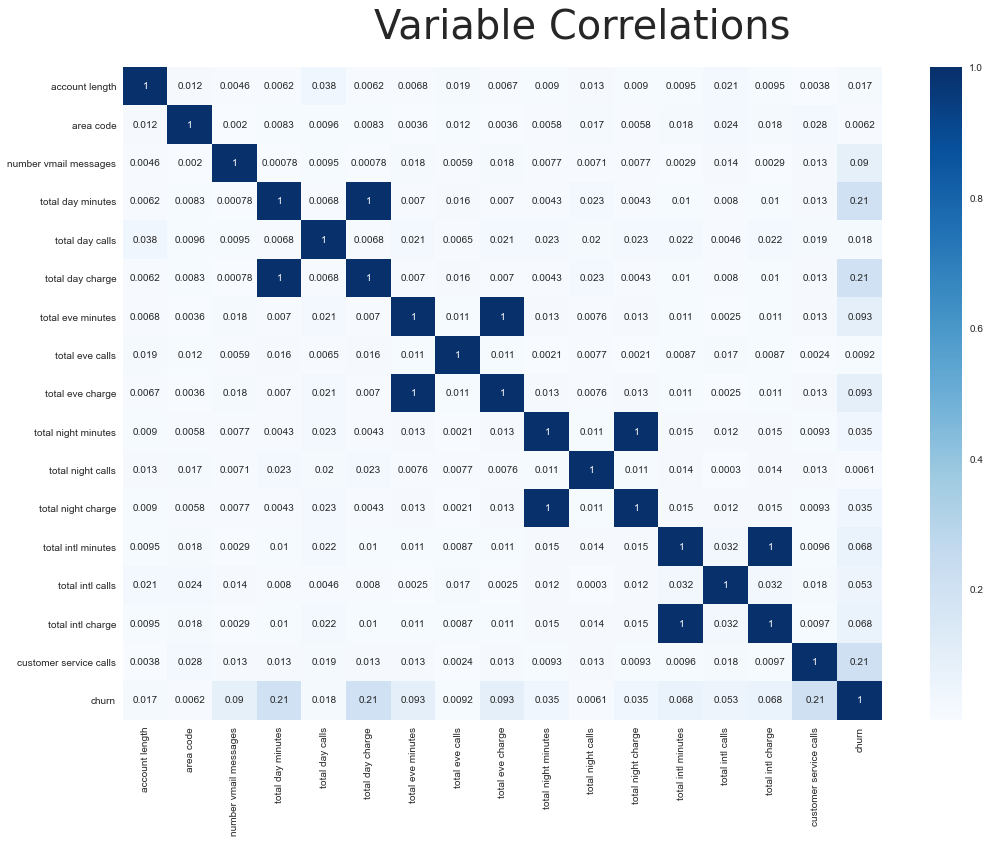

In [10]:
#checking variable correlations 
corr = df.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

In [11]:
#df1 = df1[[x for x in df1 if not x.endswith('_charge')]]
df.columns = df.columns.str.replace(' ', '_')
df = df.drop([x for x in df.columns if x.endswith('_charge')],axis=1)
#dropping phone number because it is basically a Unique ID which we do not need for this data set 
df.drop('phone_number', axis=1, inplace=True)
df

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,KS,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,OH,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,NJ,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,OH,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,OK,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,156.2,77,215.5,126,279.1,83,9.9,6,2,False
3329,WV,68,415,no,no,0,231.1,57,153.4,55,191.3,123,9.6,4,3,False
3330,RI,28,510,no,no,0,180.8,109,288.8,58,191.9,91,14.1,6,2,False
3331,CT,184,510,yes,no,0,213.8,105,159.6,84,139.2,137,5.0,10,2,False


In [12]:
#one hot encoding 
origin = df['state']
origin_series = pd.Series(origin)
df['state'] = origin_series.astype('category')
df['state'] = df['state'].cat.codes
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,16,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,35,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,31,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,35,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,36,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


In [13]:
#Converting international_plan, voice_mail_plan, and churn to be 1 or 0 
#1= yes/true 0= no/false
df['international_plan'] = df['international_plan'].map(lambda x:1 if x == 'yes' else 0)
df['voice_mail_plan'] = df['voice_mail_plan'].map(lambda x:1 if x == 'yes' else 0)
df['churn'] = df['churn'].map(lambda x:1 if x == True else 0)

df

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,16,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,49,68,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,39,28,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,6,184,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0


In [14]:
#Defining churn as our target (y)
#Defining the rest of the columns as our features (X)
y = df['churn']
X = df.drop(columns='churn', axis=1)

In [15]:
#sns.plot() #put in as image using markdown 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   int8   
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   international_plan      3333 non-null   int64  
 4   voice_mail_plan         3333 non-null   int64  
 5   number_vmail_messages   3333 non-null   int64  
 6   total_day_minutes       3333 non-null   float64
 7   total_day_calls         3333 non-null   int64  
 8   total_eve_minutes       3333 non-null   float64
 9   total_eve_calls         3333 non-null   int64  
 10  total_night_minutes     3333 non-null   float64
 11  total_night_calls       3333 non-null   int64  
 12  total_intl_minutes      3333 non-null   float64
 13  total_intl_calls        3333 non-null   int64  
 14  customer_service_calls  3333 non-null   

In [17]:
#setting up our train/test split
#stratifying the data due to the large imablance in target classes 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, stratify=y)
# Check size of train and test sets
print(len(X_train), len(X_test), len(y_train), len(y_test))

2499 834 2499 834


## Model 1: Logistic Regression 

In [18]:
lr= LogisticRegression(random_state = 56)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       713
           1       0.50      0.07      0.13       121

    accuracy                           0.85       834
   macro avg       0.68      0.53      0.53       834
weighted avg       0.81      0.85      0.81       834



### Scaling the Data

In [20]:
#Instantiate StandardScaler
scaler = StandardScaler()

#Transform X_train to scaled data set and fit the model with scaled X train data
scaled_X_train = scaler.fit_transform(X_train)

#Transform X_test to scaled data set
scaled_X_test= scaler.transform(X_test)

#Convert scaled data into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train,columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=X_test.columns)

### Smotec
From the above data we can see that there is a class imbalance so we will use SMOTEC to synthesize data to level out the imbalance. 



In [21]:
from imblearn.over_sampling import SMOTE,SMOTENC
# Create instance of smotec
smote = SMOTENC(categorical_features=[1,2],random_state=123)

# Create resampled version of the train dataset
resampled_X_train, resampled_y_train = smote.fit_resample(scaled_X_train, y_train)

Let's run the logistic regression again on our resampled data. 

In [37]:
lr.fit(resampled_X_train, resampled_y_train)
y_pred = lr.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       713
           1       0.35      0.81      0.49       121

    accuracy                           0.75       834
   macro avg       0.65      0.78      0.66       834
weighted avg       0.87      0.75      0.79       834



## Decision Tree

In [38]:
# Instantiate a DecisionTreeClassifier()
dt= DecisionTreeClassifier(max_depth=3, random_state=56)

In [39]:
#running a decision tree on our imbalanced dataset
dt.fit(X_train, y_train)
y_pred = dt.predict(scaled_X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       713
           1       0.75      0.02      0.05       121

    accuracy                           0.86       834
   macro avg       0.80      0.51      0.49       834
weighted avg       0.84      0.86      0.80       834



In [40]:
#running a decision tree on our balanced dataset
dt.fit(resampled_X_train, resampled_y_train)
y_pred = dt.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       713
           1       0.49      0.79      0.60       121

    accuracy                           0.85       834
   macro avg       0.72      0.82      0.76       834
weighted avg       0.89      0.85      0.86       834



## Random Forest

In [41]:
rf = RandomForestClassifier(random_state =56)

In [42]:
#running a Random Forest on our imbalanced dataset
rf.fit(X_train, y_train)
y_pred = rf.predict(scaled_X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       713
           1       0.46      0.37      0.41       121

    accuracy                           0.85       834
   macro avg       0.68      0.65      0.66       834
weighted avg       0.83      0.85      0.84       834



In [43]:
#running a random forest on our balanced dataset
rf.fit(resampled_X_train, resampled_y_train)
y_pred = rf.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       713
           1       0.81      0.71      0.76       121

    accuracy                           0.93       834
   macro avg       0.88      0.84      0.86       834
weighted avg       0.93      0.93      0.93       834



## XG Boost Model

In [48]:
xg = XGBClassifier(random_state =56)

In [49]:
#running XG Boost Model on our imbalanced dataset
xg.fit(X_train, y_train)
y_pred = xg.predict(scaled_X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       713
           1       0.46      0.37      0.41       121

    accuracy                           0.85       834
   macro avg       0.68      0.65      0.66       834
weighted avg       0.83      0.85      0.84       834



In [51]:
#running XG Boost on our resampled data 
xg.fit(resampled_X_train, resampled_y_train)
y_pred = xg.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       713
           1       0.92      0.75      0.83       121

    accuracy                           0.95       834
   macro avg       0.94      0.87      0.90       834
weighted avg       0.95      0.95      0.95       834



## Hypertuning the best model 
gridsearch 

im = imbalanced dataset b= balanced dataset

|Model     |Recall   |Accuracy|
|--------------|-----------|------------|
|logistic regression (im) |0.07  |0.85      |
|logistic regression (b)   |0.81  |0.75     |
|decision tree (im) |0.02 |0.86 |
|decision tree (b) | 0.79 | 0.85 |
|random forest (im) | 0.37 | 0.85 |
|random forest (b) | 0.71 | 0.93 |
|xg (im) | 0.37 | 0.85 |
|xg (b) | 0.75 | 0.95 |


### Using Grid Search for parameter tuning on balanced logistic regression

In [55]:
clf = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
gs_lr = GridSearchCV(clf, param_grid = param_grid ,scoring = 'recall')
gs_lr.fit(resampled_X_train, resampled_y_train)
best_parameters = gs_lr.best_params_


print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = gs_lr.predict(resampled_X_train)
test_preds = gs_lr.predict(X_test)
training_accuracy = accuracy_score(resampled_y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
C: 5
penalty: 'l2'

Training Accuracy: 77.84%
Validation accuracy: 14.51%


In [56]:
lr_grid=LogisticRegression(penalty='l2', C = 5)

In [58]:
lr_grid.fit(resampled_X_train, resampled_y_train)
y_pred = lr_grid.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       713
           1       0.35      0.81      0.49       121

    accuracy                           0.75       834
   macro avg       0.65      0.78      0.66       834
weighted avg       0.87      0.75      0.79       834



### Using Grid Search for parameter tuning on balanced decision tree model

In [80]:
clf = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2, 5, 10, 15, 20, 100, 150, 250, 500, 1000],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(dt, param_grid, cv=3,scoring='recall', n_jobs=1)
gs_tree.fit(resampled_X_train, resampled_y_train)

best_parameters = gs_tree.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = gs_tree.predict(resampled_X_train)
test_preds = gs_tree.predict(X_test)
training_accuracy = accuracy_score(resampled_y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))


Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 100
min_samples_split: 5

Training Accuracy: 99.09%
Validation accuracy: 14.15%


In [88]:
dt_grid = DecisionTreeClassifier(criterion='gini', max_depth = 100, min_samples_split=5)


In [89]:
dt_grid.fit(resampled_X_train, resampled_y_train)
y_pred = dt_grid.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       713
           1       0.58      0.74      0.65       121

    accuracy                           0.88       834
   macro avg       0.77      0.82      0.79       834
weighted avg       0.90      0.88      0.89       834



ht = hypertuned n = not hypertuned

|Model     |Recall   |Accuracy|
|--------------|-----------|------------|
|logistic regression (ht) |0.81  |0.75      |
|logistic regression (n)   |0.81  |0.75     |
|decision tree (ht) |0.74 |0.88 |
|decision tree (n) | 0.79 | 0.85 |

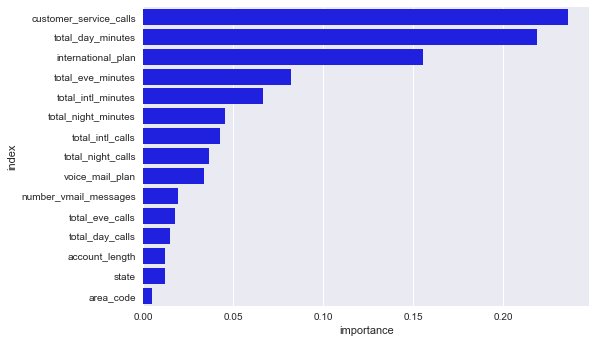

In [93]:
# Calculate feature importances
feature_importances = dt_grid.feature_importances_

# Create a list of features: done
feature_list = list(resampled_X_train.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

-adding boxplots 
-balanced decision tree is best model 
-check for overfitting 
-calculating which features are most important
-decision tree and how those features are impacted by tuning 
-how we envision model being used 
-communicating to shareholders the features of importance 
-sklearn feature_importances_ which will return a list of features of their importance (basically coefficients)
-https://towardsdatascience.com/feature-importance-in-decision-trees-e9450120b445